# Moteur de recherche avec embedding pre-entrainés GPT-2

Dans ce notebook, nous avons créé un moteur de recherche qui parcourt la collection de questions StackOverFlow Python et récupère les questions et les tags les plus similaires à la question d'entrée

In [1]:
from IPython.core.display import display
!pip install transformers

In [2]:
!pip install simpletransformers==0.32.3

In [3]:
!pip install wordcloud

In [4]:
!pip install torch

In [5]:
import pandas as pd
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud , STOPWORDS
import matplotlib.pyplot as plt
from transformers import (GPT2Config,GPT2LMHeadModel,GPT2Tokenizer)
from tqdm.notebook import tqdm
import torch

pd.set_option('display.max_colwidth', None)

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/fedecabre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
#questions = pd.read_csv("input/Questions.csv", encoding = "ISO-8859-1")
#print(len(questions))
#display(questions.head(5))

dtypes_questions = {'Id':'int32', 'Score': 'int16', 'Title': 'str',
                    'Body': 'str', 'Title_raw': 'str', 'Text': 'str'}

nrows = 1000

df_questions = pd.read_csv('df_questions_fullclean.csv',
                           usecols=dtypes_questions.keys(),
                           encoding = "utf-8",
                           dtype=dtypes_questions,
                           nrows=nrows
                          )

df_tags_list = pd.read_csv('tags_list.csv',
                           usecols=['Id', 'Tags'],
                           encoding = "utf-8",
                           dtype=dtypes_questions,
                           #nrows=nrows # un post peut avoir plusieurs tags
                          )
print(len(df_questions))
display(df_questions.head(5))
display(df_tags_list.head(5))

1000


,Id,Title,Body,Score,Title_raw,Text
0,5649407,string array python,long string represent series value type convert hex string array shift value convert proper data type,182,hexadecimal string to byte array in python,string array python long string represent series value type convert hex string array shift value convert proper data type
1,7974849,make one python file run another,make one python file run another example two py file want one file run run py file,355,How can I make one python file run another?,make one python file run another make one python file run another example two py file want one file run run py file
2,29554796,mean band width ggplot geomsmooth lm,follow code libraryggplot ggplotmtcars aesxwt geompointaescolourfactorcyl geomsmoothmethodlm get question grey zone define mean play around parameter control width band,32,Meaning of band width in ggplot geom_smooth lm,mean band width ggplot geomsmooth lm follow code libraryggplot ggplotmtcars aesxwt geompointaescolourfactorcyl geomsmoothmethodlm get question grey zone define mean play around parameter control width band
3,250151,lua generalpurpose script language,see thing ever read embed often anything world warcraft wow limit embed thing another application write script like python perl lua seem aspect like speed memoryusage script language afaik never see lua use scriptinglanguage automate task example rename file download file web webscraping lack library,36,Lua as a general-purpose scripting language?,lua generalpurpose script language see thing ever read embed often anything world warcraft wow limit embed thing another application write script like python perl lua seem aspect like speed memoryusage script language afaik never see lua use scriptinglanguage automate task example rename file download file web webscraping lack library
4,1342000,make python interpreter correctly character string operation,string look like way string understand python simply say string call get sreplace course complain character xc file blablapy encode never quite could understand switch encoding code really file save notepad follow header cod code f soup beautifulsoupf soupfinddiv idmaincount make print go well show sreplace savemaincounts get sreplace,104,How to make the python interpreter correctly handle non-ASCII characters in string operations?,make python interpreter correctly character string operation string look like way string understand python simply say string call get sreplace course complain character xc file blablapy encode never quite could understand switch encoding code really file save notepad follow header cod code f soup beautifulsoupf soupfinddiv idmaincount make print go well show sreplace savemaincounts get sreplace


,Id,Tags
0,5649407,python
1,5649407,bytearray
2,7974849,python
3,29554796,r
4,29554796,ggplot2


In [8]:
print(df_questions[['Title','Body']].head(10))


                                                          Title  \
0                                           string array python   
1                              make one python file run another   
2                          mean band width ggplot geomsmooth lm   
3                            lua generalpurpose script language   
4  make python interpreter correctly character string operation   
5                                     run python script webpage   
6                   python count element object match attribute   
7                                               way kill thread   
8                       python practice import offering feature   
9                           add legend ggplot line add manually   

                                                                                                                                                                                                                                                                      

In [9]:

print("Nombre de questions uniques dans les post importés: ", df_questions['Id'].nunique())
print("Nombre de questions uniques dans le tags importés: ", df_tags_list['Id'].nunique())

Nombre de questions uniques dans les post importés:  1000
Nombre de questions uniques dans le tags importés:  13886


In [10]:
# Tokenisation des posts
df_questions['qTitle'] = df_questions['Title'].apply(lambda x : len(str(x).split(" ")))
df_questions['qBody'] = df_questions['Body'].apply(lambda x : len(str(x).split(" ")))
df_questions['qText'] = df_questions['Text'].apply(lambda x : len(str(x).split(" ")))

In [11]:
print('Longueur moyen des Titres : ',df_questions['qTitle'].mean())
print('Longueur moyen des Post : ',df_questions['qBody'].mean())

Longueur moyen des Titres :  4.429
Longueur moyen des Post :  51.404


## Nombre de mots dans le titre et le corps

Text(0.5, 1.0, 'Nombre de mots dans le Titre')

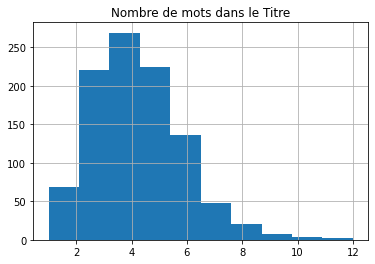

In [12]:
fig = plt.figure()
fig.patch.set_facecolor('w')
df_questions['qTitle'].hist(bins=10)
plt.title("Nombre de mots dans le Titre")

Text(0.5, 1.0, 'Nombre de mots dans les post')

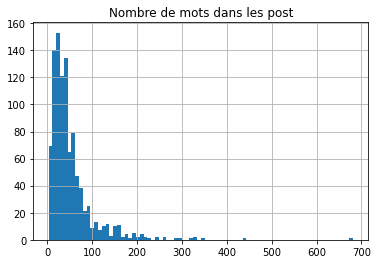

In [13]:
fig = plt.figure()
fig.patch.set_facecolor('w')
df_questions['qBody'].hist(bins=80)
plt.title("Nombre de mots dans les post")

La plupart des titres ont environ 4 mots tandis que pour Body, il se situe autour de 52. Donc, pour obtenir les questions les plus similaires, nous allons utiliser le Title au lieu de Body.

## Word Cloud

In [14]:
def getWordCloud(df,col):
    comment_words = ''
    stopwords = set(STOPWORDS)
    stopwords.add('nan')
    stopwords.add('use')
    stopwords.add('way')
    stopwords.add('one')

    for val in tqdm(df[col]):

        val = str(val)
        tokens = val.split()

        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='white',
                          stopwords = stopwords,
                          min_font_size = 10,
                          min_word_length=2).generate(comment_words)


    plt.figure(figsize = (10, 10), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

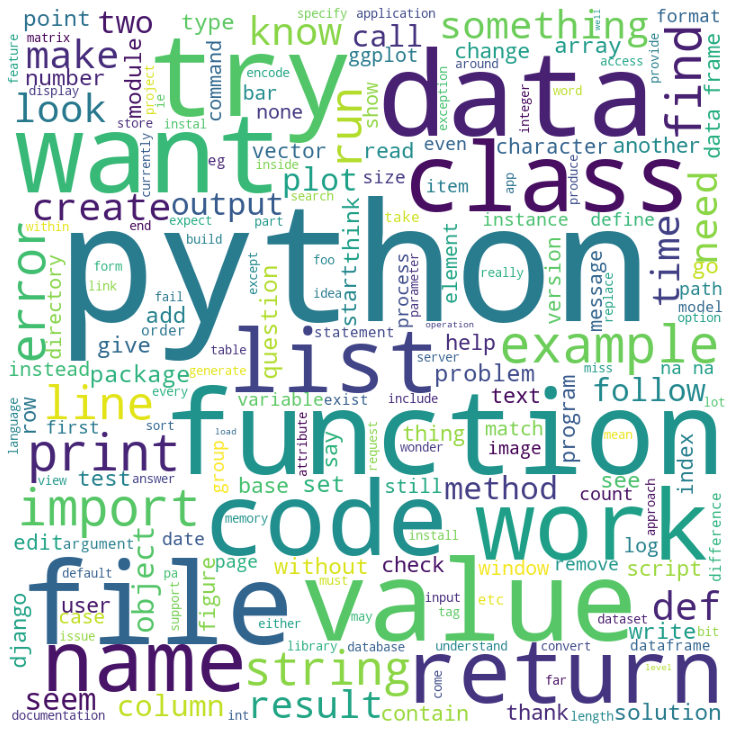

In [15]:
getWordCloud(df_questions,'Text')

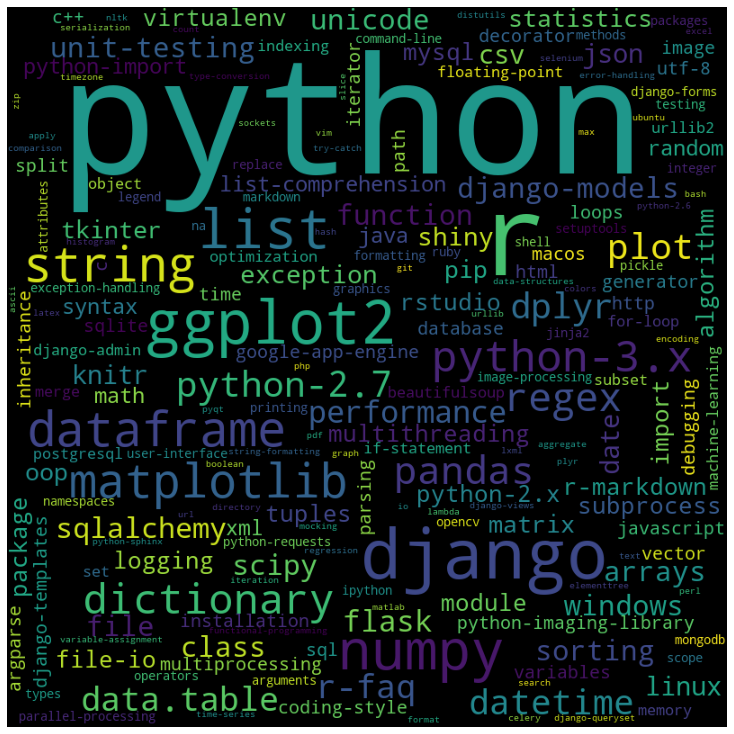

In [16]:
tag_freq = df_tags_list['Tags'].value_counts().sort_values(ascending = False)[:200]

wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='black',
                      stopwords = None,
                      min_font_size = 10,
                      regexp="(?u)\\b\\w+\\b",
                      min_word_length=0).fit_words(tag_freq)


plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [17]:
tag_freq[:33]

python           10069
r                 3940
django             841
ggplot2            632
list               526
numpy              521
dataframe          395
string             394
matplotlib         367
python-3.x         313
dictionary         286
regex              255
pandas             240
plot               209
python-2.7         207
dplyr              200
datetime           186
r-faq              180
data.table         180
performance        155
flask              149
scipy              144
sqlalchemy         143
arrays             137
django-models      136
function           133
file               130
windows            129
unit-testing       128
unicode            125
class              124
sorting            122
csv                109
Name: Tags, dtype: int64

## Prétraitement du titre - Suppression des mots vides, des caractères non alphanumériques et de tous les caractères en minuscules.

In [18]:
stop = stopwords.words('english')
def preprocess(df, col):
    df['preprocessed'+col] = df[col].apply(lambda x : " ".join([word for word in str(x).split(" ") if word not in stop]))
    df['preprocessed'+col] = df['preprocessed'+col].str.replace('[^a-zA-Z0-9 ]', '')
    df['preprocessed'+col] = df['preprocessed'+col].str.lower()
    return df

In [19]:
questions = preprocess(df_questions, 'Title')

<ipython-input-18-f22b149ba5f6>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['preprocessed'+col] = df['preprocessed'+col].str.replace('[^a-zA-Z0-9 ]', '')


## Tags

In [20]:
print(len(df_tags_list))
display(df_tags_list.head(5))

40860


,Id,Tags
0,5649407,python
1,5649407,bytearray
2,7974849,python
3,29554796,r
4,29554796,ggplot2


In [21]:
print("Nombre de tags uniques : ", df_tags_list['Tags'].nunique())

Nombre de tags uniques :  3361


20 Tags les plus fréquents Sauf Python et r qui sont évidemment le plus fréquent.

<AxesSubplot:>

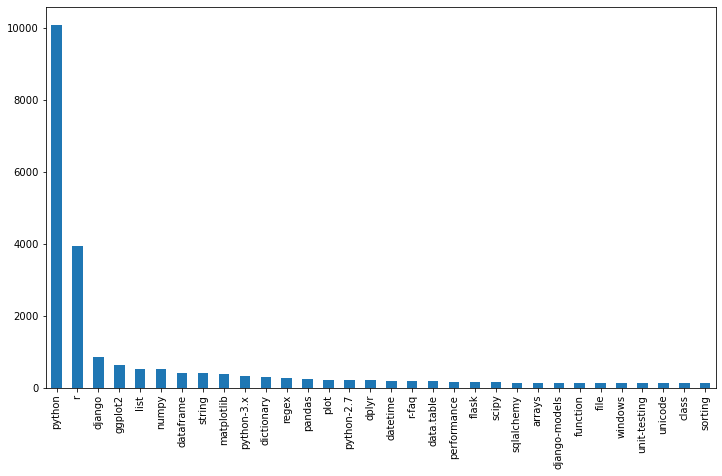

In [22]:
fig, ax = plt.subplots(figsize = (12, 7))
fig.patch.set_facecolor('w')
df_tags_list['Tags'].value_counts().sort_values(ascending = False)[:32].plot(ax=ax, kind='bar')

<ipython-input-23-a0dd0ee09bb9>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tags_list[df_tags_list['Tags']!='python'][df_tags_list['Tags']!='r']['Tags'].value_counts().sort_values(ascending = False)[:30].plot(ax=ax, kind='bar')


<AxesSubplot:>

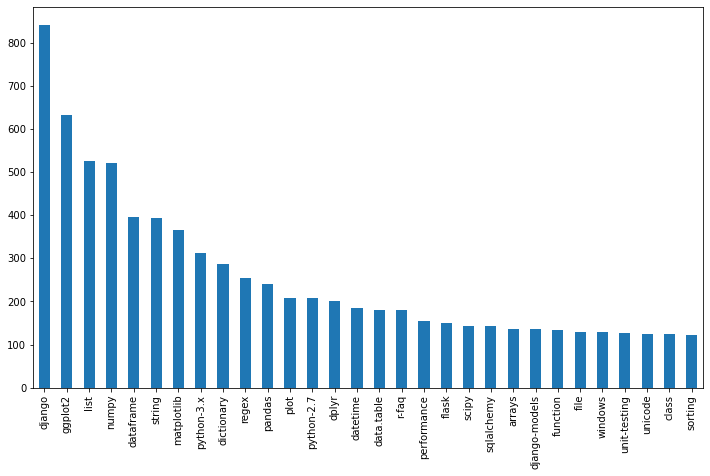

In [23]:
fig, ax = plt.subplots(figsize = (12, 7))

fig.patch.set_facecolor('w')

df_tags_list[df_tags_list['Tags']!='python'][df_tags_list['Tags']!='r']['Tags'].value_counts().sort_values(ascending = False)[:30].plot(ax=ax, kind='bar')


## Codage du titre de la question traitée et intégration à l'aide de GPT2 Tokenizer.

In [24]:
config_class, model_class, tokenizer_class = GPT2Config, GPT2LMHeadModel, GPT2Tokenizer
model = model_class.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [25]:
preprocessedTitle = df_questions['Title'].values
QID = df_questions['Id'].values
print(len(preprocessedTitle), len(QID))

1000 1000


Utilisation de tokenizer.batch_encode_plus pour encoder tous les titres en une seule fois. Au lieu de tokenizer.batch_encode_plus, tokenizer.encode peut être utilisé pour encoder 1 instance à la fois

In [26]:
encodedpreprocessedTitle = tokenizer.batch_encode_plus(preprocessedTitle)['input_ids']
print(len(encodedpreprocessedTitle))

1000


Chargement de l’embedding à partir du modèle GPT2. Chaque token dans la "embedding matrix”  est un vecteur de longueur 768 et l’embedding a 50257 uniques tokens.

In [27]:
embeddigs = model.transformer.wte
print("Shape de l' embedding matrix : ",embeddigs.weight.shape)
print("Type de l' embedding matrix : ", type(embeddigs))

Shape de l' embedding matrix :  torch.Size([50257, 768])
Type de l' embedding matrix :  <class 'torch.nn.modules.sparse.Embedding'>


 Dans le code ci-dessous, Nous avons pris la moyenne à travers des embeddings de tous les tokens dans un titre particulier. Ainsi, après avoir pris la moyenne, chaque titre serait représenté par un vecteur de longueur 768. Et la même chose a été faite pour tous les 607282 titres dans une boucle for.
 
 
Remarque - Il peut y avoir des cas où le nombre de jetons dans le titre traité peut être égal à 0, d'où la condition de len (encodedTitle)> 0 a été appliquée.

In [28]:
TitleEmbeddingList = []
QIDList = []
for idx, (qid, encodedTitle) in tqdm(enumerate(zip(QID, encodedpreprocessedTitle))):
    if len(encodedTitle) > 0 :
        embeddedTitle = embeddigs(torch.tensor(encodedTitle).to(torch.int64)).mean(axis=0)
        TitleEmbeddingList.append(embeddedTitle)
        QIDList.append(qid)

In [29]:
numQ = len(TitleEmbeddingList)
embedDim = len(TitleEmbeddingList[0])
print("Nombre de Titres : ",numQ," et longueur du vecteur de chaque titre : ",embedDim)

Nombre de Titres :  1000  et longueur du vecteur de chaque titre :  768


In [30]:
print("Type de TitleEmbeddingList : ",type(TitleEmbeddingList))

Type de TitleEmbeddingList :  <class 'list'>


## Conversion de TitleEmbeddingList de "liste de tenseurs" en tenseur.

In [31]:
TitleEmbeddingTensor = torch.cat(TitleEmbeddingList, dim=0)
TitleEmbeddingTensor = torch.reshape(TitleEmbeddingTensor, (numQ, embedDim))
print("Shape de TitleEmbeddingTensor : ",TitleEmbeddingTensor.shape)
print("Type de TitleEmbeddingTensor : ", type(TitleEmbeddingTensor))

Shape de TitleEmbeddingTensor :  torch.Size([1000, 768])
Type de TitleEmbeddingTensor :  <class 'torch.Tensor'>


Une fois que nous avons créé la représentation avec l’embedding pour chaque titre. Nous allons maintenant entrer une question et rechercher parmi les titres de question StackOverflow lesquels sont les plus similaires à l'entrée en utilisant la similitude cosinus entre l’embedding de la question d'entrée et les titres.

## PreProcess du texte des titres

In [32]:
def preprocesstext(text):
    text =  " ".join([word for word in text.split(" ") if word not in stop])
    text = re.sub(r'[^a-zA-Z0-9 ]','',text)
    text = text.lower()
    return text

Effectuer une similarité cosinus entre la question entrée et tous les titres StackOverFlow et obtenir l'index des titres K les plus similaires

In [33]:
def getMostSimilarQuestionsIdx(K, a, b):
    a_norm = a / a.norm(dim=1)[:, None]
    b_norm = b / b.norm(dim=1)[:, None]
    res = torch.mm(a_norm, b_norm.transpose(0,1)).squeeze(0)
    res = res.tolist()
    mostSimIdx = sorted(range(len(res)), key=lambda x: res[x])[-K:]
    return mostSimIdx

## Afficher les titres de questions les plus similaires avec l'ID de question et les tags associés

In [34]:
def getMostSimilarQuestions(K, input, QuestionDF, QIDList, Tags):
    input = input
    preprocessedinput = preprocesstext(input)
    inputEncoded = tokenizer.batch_encode_plus([preprocessedinput])['input_ids']
    inputEmbedded = embeddigs(torch.tensor(inputEncoded).to(torch.int64)).squeeze(0).mean(axis=0).unsqueeze(0)
    mostSimilarIdx = getMostSimilarQuestionsIdx(K, inputEmbedded, TitleEmbeddingTensor)
    mostSimilarIdx.reverse()
    print("Most similar ",K, " questions of : ",input,'\n')
    for idx, simidx in enumerate(mostSimilarIdx):
        IDQ = QuestionDF[QuestionDF['Id']==QIDList[simidx]][['Id','Title_raw']].values
        parentId = IDQ[0][0]
        simQuestion = IDQ[0][1]
        print((idx+1), "Question Id : ", parentId, "\n", "Question : ",simQuestion)
        similar_tags = Tags[Tags['Id']==QIDList[simidx]][['Tags']].values
        tags_list =  " , ".join([word for word in similar_tags[:,0]])
        print("Tags suggérés : ", tags_list, "\n")

## Test

In [35]:
tag_list=getMostSimilarQuestions(5, "How to MUltiply 2 columns in pandas ?", df_questions ,QIDList, df_tags_list)

Most similar  5  questions of :  How to MUltiply 2 columns in pandas ? 

1 Question Id :  17141558 
 Question :  How to sort a dataFrame in python pandas by two or more columns?
Tags suggérés :  python , pandas , python-2.7 , sorting , data-analysis 

2 Question Id :  13611065 
 Question :  Efficient way to apply multiple filters to pandas DataFrame or Series
Tags suggérés :  python , algorithm , pandas 

3 Question Id :  13156448 
 Question :  How can I sort a data.frame with only one column, without losing rownames?
Tags suggérés :  r , sorting , dataframe 

4 Question Id :  12439588 
 Question :  How to maximize a plt.show() window using Python
Tags suggérés :  python , matplotlib 

5 Question Id :  21752425 
 Question :  dplyr mutate in R - add column as concat of columns
Tags suggérés :  r , dataframe , dplyr , concat 



In [36]:
getMostSimilarQuestions(5, "regex pandas", df_questions ,QIDList, df_tags_list)

Most similar  5  questions of :  regex pandas 

1 Question Id :  9134964 
 Question :  Regex in python: is it possible to get the match, replacement, and final string?
Tags suggérés :  python , regex 

2 Question Id :  17141558 
 Question :  How to sort a dataFrame in python pandas by two or more columns?
Tags suggérés :  python , pandas , python-2.7 , sorting , data-analysis 

3 Question Id :  13611065 
 Question :  Efficient way to apply multiple filters to pandas DataFrame or Series
Tags suggérés :  python , algorithm , pandas 

4 Question Id :  16852911 
 Question :  How do I convert strings in a Pandas data frame to a 'date' data type?
Tags suggérés :  python , date , pandas 

5 Question Id :  9347406 
 Question :  how to refer to a parent method in python?
Tags suggérés :  python , inheritance , polymorphism 



In [37]:
getMostSimilarQuestions(5, "logistic regression sklearn", df_questions ,QIDList, df_tags_list)

Most similar  5  questions of :  logistic regression sklearn 

1 Question Id :  15180008 
 Question :  How to calculate the 95% confidence interval for the slope in a linear regression model in R
Tags suggérés :  r , statistics , linear-regression , confidence-interval 

2 Question Id :  12937331 
 Question :  Why is it inadvisable to get statistical summary information for regression coefficients from glmnet model?
Tags suggérés :  r , statistics , regression , glm , glmnet 

3 Question Id :  6167587 
 Question :  The logging.handlers: How to rollover after time or maxBytes?
Tags suggérés :  python , logging , handlers 

4 Question Id :  6910814 
 Question :  calculate distance between regression line and datapoint
Tags suggérés :  r , plot , distance 

5 Question Id :  14102416 
 Question :  Python Requests requests.exceptions.SSLError: [Errno 8] _ssl.c:504: EOF occurred in violation of protocol
Tags suggérés :  python , openssl , httprequest , python-requests , ubuntu-12.10 



In [38]:
getMostSimilarQuestions(5, "covert csv to json file pandas", df_questions ,QIDList, df_tags_list)

Most similar  5  questions of :  covert csv to json file pandas 

1 Question Id :  3103327 
 Question :  Reading .csv in Python without looping through the whole file?
Tags suggérés :  python , csv , iterator , next 

2 Question Id :  431752 
 Question :  Python csv.reader: How do I return to the top of the file?
Tags suggérés :  python , csv 

3 Question Id :  3428532 
 Question :  How to import a csv file using python with headers intact, where first column is a non-numerical
Tags suggérés :  python , csv 

4 Question Id :  13999850 
 Question :  How to specify date format when using pandas.to_csv?
Tags suggérés :  python , pandas , export-to-csv , datetime-format , date-formatting 

5 Question Id :  17141558 
 Question :  How to sort a dataFrame in python pandas by two or more columns?
Tags suggérés :  python , pandas , python-2.7 , sorting , data-analysis 



In [39]:
getMostSimilarQuestions(5, "How to install Pandas", df_questions ,QIDList, df_tags_list)

Most similar  5  questions of :  How to install Pandas 

1 Question Id :  13611065 
 Question :  Efficient way to apply multiple filters to pandas DataFrame or Series
Tags suggérés :  python , algorithm , pandas 

2 Question Id :  17141558 
 Question :  How to sort a dataFrame in python pandas by two or more columns?
Tags suggérés :  python , pandas , python-2.7 , sorting , data-analysis 

3 Question Id :  12439588 
 Question :  How to maximize a plt.show() window using Python
Tags suggérés :  python , matplotlib 

4 Question Id :  16852911 
 Question :  How do I convert strings in a Pandas data frame to a 'date' data type?
Tags suggérés :  python , date , pandas 

5 Question Id :  13999850 
 Question :  How to specify date format when using pandas.to_csv?
Tags suggérés :  python , pandas , export-to-csv , datetime-format , date-formatting 

